# WWOX

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.4.2.dev0


### WWOX
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for WWOX.

In [3]:
gene_symbol = 'WWOX'
mane_tx_id = 'NM_016373.4'
mane_protein_id = "NP_057457.1" 

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets


phenopacket_store_release = '0.1.20'


registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed:   0%|          | 0/34 [00:00<?, ?individuals/s]

Expected a result but got an Error for variant: 16_78386858_78386858_A_--45894bp--
<html><body><h1>400 Bad request</h1>
Your browser sent an invalid request.
</body></html>



Individuals Processed: 100%|██████████| 34/34 [00:04<00:00,  6.99individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #0
    variants
      #0
       warnings:
       ·Patient PMID_30356099_Patient_1 has an error with variant 16_78386858_78386858_A_--45894bp--. Try again or remove variant form testing... Expected a result but got an Error. See log for details.
  patient #10
    variants
     errors:

      #0
       warnings:
       ·Patient PMID_25411445_Patient_1 has an error with variant SO:1000029_HGNC:12799_WWOX. Try again or remove variant form testing... Could not parse CDS start and end from given coordinates
       ·Patient PMID_25411445_Patient_1 has an error with variant SO:1000029_HGNC:12799_WWOX. Try again or remove variant form testing... Could not parse CDS start and end from given coordinates
  patient #20
    variants
      #0
       warnings:
       ·Patient PMID_25411445_Patient_2 has an error with variant SO:1000029_HGN

In [6]:
from gpsea.view import CohortViewable
viewer = CohortViewable(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=WWOX_MANE_transcript)


HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,34
EEG abnormality,HP:0002353,29
Epileptic encephalopathy,HP:0200134,28
Hypokinesia,HP:0002375,20
Reduced eye contact,HP:0000817,19
Thin corpus callosum,HP:0033725,17
Spasticity,HP:0001257,15
Cerebral atrophy,HP:0002059,14
Bilateral tonic-clonic seizure,HP:0002069,11
Axial hypotonia,HP:0008936,10


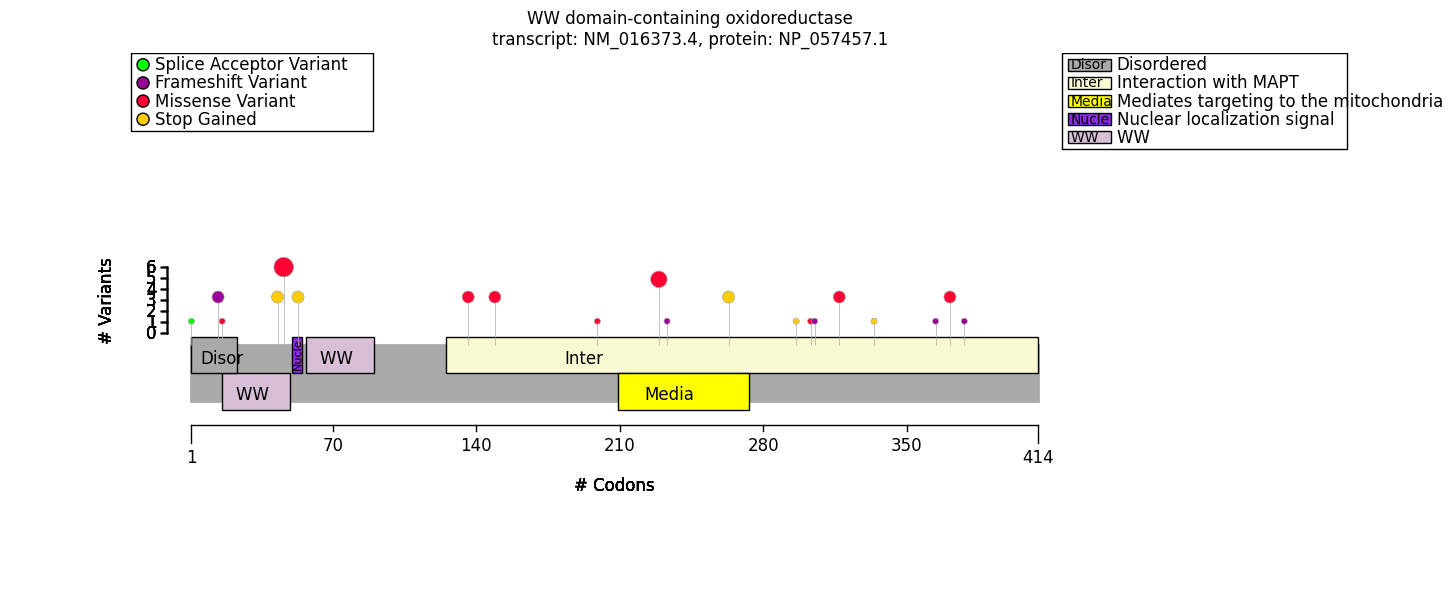

In [7]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

"""
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)
"""

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [8]:
from gpsea.view import ProteinVariantViewer

viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Name,Type,Coordinates,Count,Variants
Disordered,REGION,1 - 23,4,p.Asp16SerfsTer63; p.Glu17Lys; p.Met1_?137
WW 1,DOMAIN,16 - 49,10,p.Glu17Lys; p.Pro47Thr; p.Met1_?137; p.Trp44Ter; p.Pro47Arg
Nuclear localization signal,MOTIF,50 - 55,3,p.Arg54Ter; p.Met1_?137
WW 2,DOMAIN,57 - 90,1,p.Met1_?137
Interaction with MAPT,REGION,125 - 414,23,p.His150Pro; p.Val365AlafsTer163; p.Gly372Arg; p.Lys297Ter; p.Trp335Ter; p.Met1_?137; p.Arg264Ter; p.Glu306AspfsTer21; p.His236AlafsTer34; p.Lys200Glu; p.Ser304Phe; p.Ser318Leu; p.Cys380LeufsTer149; p.Gly137Glu; p.Gln230Pro
Mediates targeting to the mitochondria,REGION,209 - 273,7,p.His236AlafsTer34; p.Gln230Pro; p.Arg264Ter


In [10]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [11]:

from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant
from gpsea.model import VariantEffect


is_fs = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)

gt_predicate = autosomal_dominant(
    variant_predicate=is_fs,
)

gt_predicate.display_question()

'What is the genotype group: HOM_REF, HET'

In [12]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,9
HMF04,Skipping term because all genotypes have same HPO observed proportions,32
HMF05,Skipping term because one genotype had zero observations,2
HMF06,Skipping term with less than 7 observations (not powered for 2x2),73
HMF08,Skipping general term,37


In [13]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group                         HOM_REF           HET  \
                                                     Count Percent Count   
Hyperreflexia [HP:0001347]                             5/6     83%   0/2   
Epileptic spasm [HP:0011097]                          5/19     26%   4/6   
Optic atrophy [HP:0000648]                            2/16     12%   2/5   
Thin corpus callosum [HP:0033725]                    14/18     78%   3/6   
Cerebral atrophy [HP:0002059]                        12/21     57%   2/6   
Ataxia [HP:0001251]                                   6/10     60%   0/2   
Gait ataxia [HP:0002066]                               4/8     50%   0/2   
Decreased fetal movement [HP:0001558]                 2/15     13%   1/4   
Hypokinesia [HP:0002375]                             15/18     83%   4/6   
Reduced eye contact [HP:0000817]                     15/18     83%   4/6   
Axial hypotonia [HP:0008936]                           7/9     78%   3/5   
Spasticity [HP:0001257]                              12/16     75%   3/5   
Bilateral tonic-clonic seizure with focal onset...    5/20     25%   2/6   
Focal clonic seizure [HP:0002266]                     5/19     26%   1/6   
Abnormal electroretinogram [HP:0000512]               5/12     42%   1/4   
Narrow forehead [HP:0000341]                          3/15     20%   0/4   
Uplifted earlobe [HP:0009909]                         3/15     20%   0/4   
Round face [HP:0000311]                               3/15     20%   1/4   

What is the genotype group                                                     \
                                                   Percent Corrected p values   
Hyperreflexia [HP:0001347]                              0%           0.896285   
Epileptic spasm [HP:0011097]                           67%           0.896285   
Optic atrophy [HP:0000648]                             40%           0.896285   
Thin corpus callosum [HP:0033725]                      50%           0.896285   
Cerebral atrophy [HP:0002059]                          33%           0.896285   
Ataxia [HP:0001251]                                     0%           0.896285   
Gait ataxia [HP:0002066]                                0%           0.896285   
Decreased fetal movement [HP:0001558]                  25%           0.896285   
Hypokinesia [HP:0002375]                               67%           0.896285   
Reduced eye contact [HP:0000817]                       67%           0.896285   
Axial hypotonia [HP:0008936]                           60%           0.896285   
Spasticity [HP:0001257]                                60%           0.896285   
Bilateral tonic-clonic seizure with focal onset...     33%           1.000000   
Focal clonic seizure [HP:0002266]                      17%           1.000000   
Abnormal electroretinogram [HP:0000512]                25%           1.000000   
Narrow forehead [HP:0000341]                            0%           1.000000   
Uplifted earlobe [HP:0009909]                           0%           1.000000   
Round face [HP:0000311]                                25%           1.000000   

What is the genotype group                                    
                                                    p values  
Hyperreflexia [HP:0001347]                          0.107143  
Epileptic spasm [HP:0011097]                        0.142451  
Optic atrophy [HP:0000648]                          0.228070  
Thin corpus callosum [HP:0033725]                   0.306844  
Cerebral atrophy [HP:0002059]                       0.384541  
Ataxia [HP:0001251]                                 0.454545  
Gait ataxia [HP:0002066]                            0.466667  
Decreased fetal movement [HP:0001558]               0.530444  
Hypokinesia [HP:0002375]                            0.568041  
Reduced eye contact [HP:0000817]                    0.568041  
Axial hypotonia [HP:0008936]                        0.580420  
Spasticity [HP:0001257]                

In [15]:
from gpsea.analysis import *
abn_putamen = hpotk.TermId.from_curie("HP:0031982")
abn_caudate_nucleus = hpotk.TermId.from_curie("HP:0002339")
term_set = {abn_putamen, abn_caudate_nucleus}

## HOW 

config = CohortAnalysisConfiguration()
config.pval_correction = 'fdr_bh'
config.specify_terms_strategy(term_set)
analysis = configure_cohort_analysis(cohort, hpo, config=config)


NameError: name 'CohortAnalysisConfiguration' is not defined

In [ ]:
type(abn_caudate_nucleus)

hpotk.model._term_id.DefaultTermId

In [ ]:
hpo

In [ ]:
abn_caudate_nucleus in hpo

True